📊 Loading data from transactions.json
✅ Loaded 100000 transactions from 3497 wallets
🔍 Extracting ML features...
🎯 Calculating target scores...
🔧 Preparing ML data...
✅ Prepared 3497 samples with 29 features
🤖 Training ML models...
   Training Random Forest...
   Training Gradient Boosting...
   Training Linear Regression...
   Training Ridge Regression...
   Training Lasso Regression...
   Training SVR...
✅ Best model: Random Forest (CV R² = 0.9852)
🎛️ Optimizing Random Forest...
✅ Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
✅ Best CV score: 0.9860
📊 Analyzing feature importance...
📈 Creating model comparison plots...


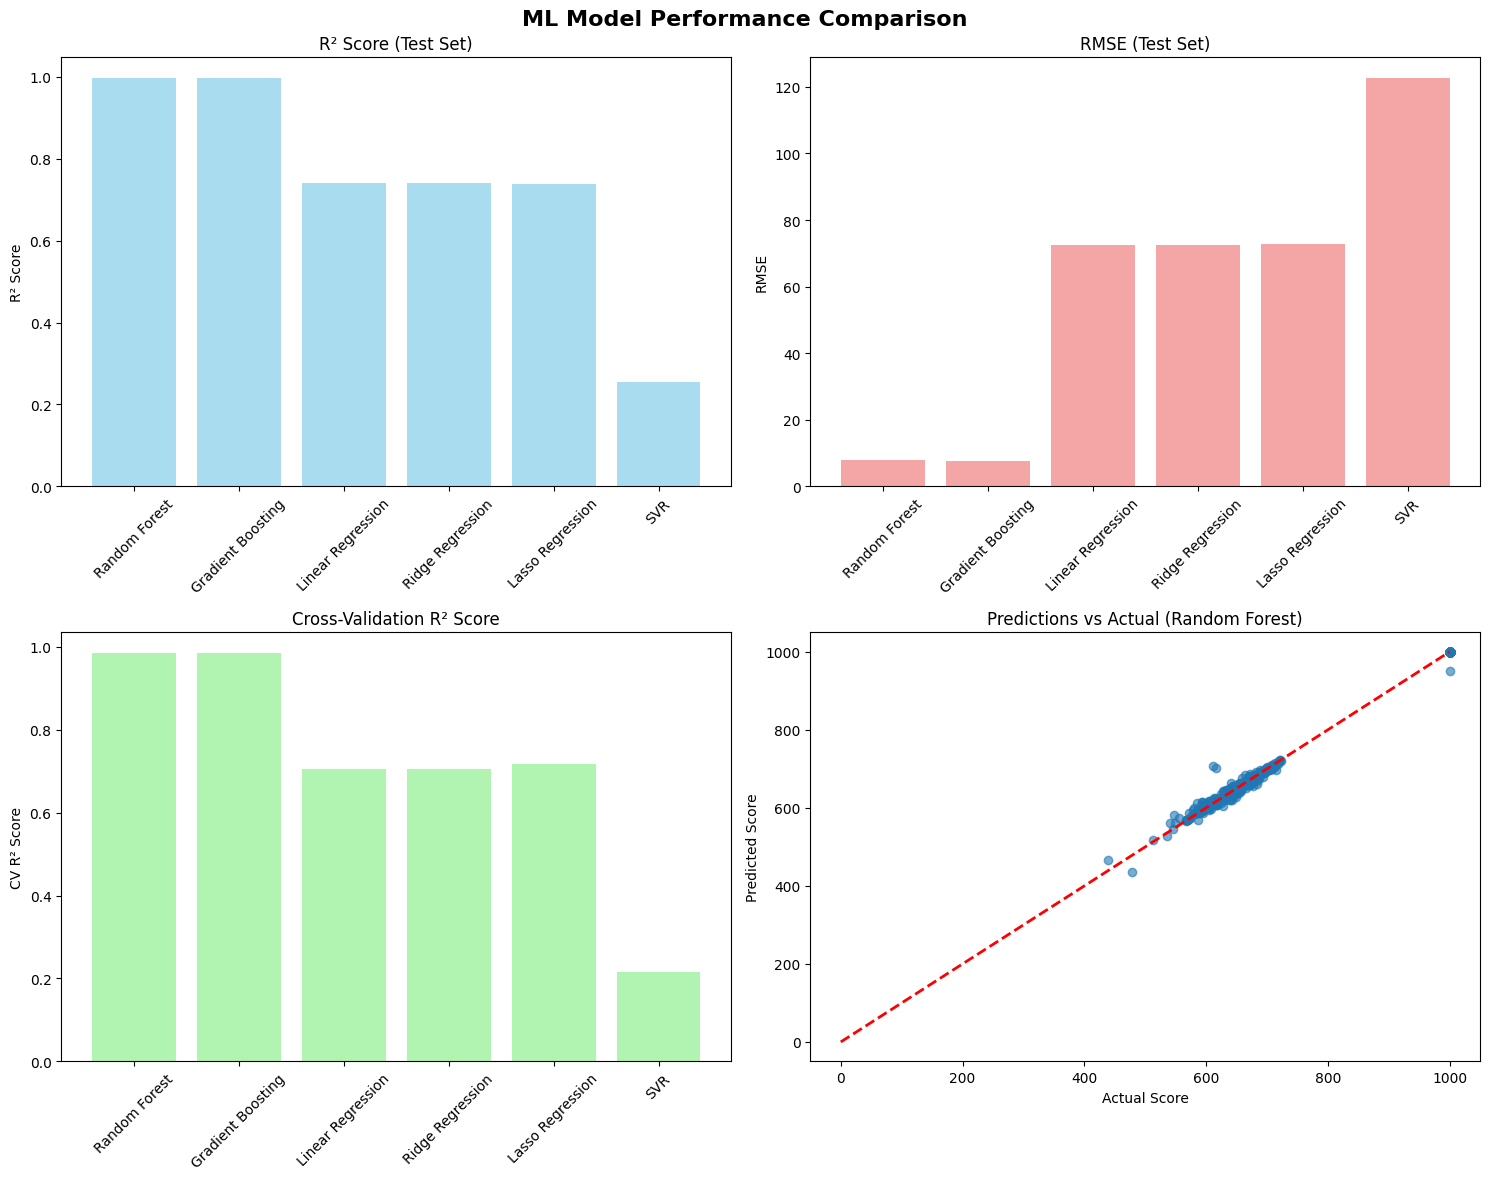

📊 Creating feature importance plot...


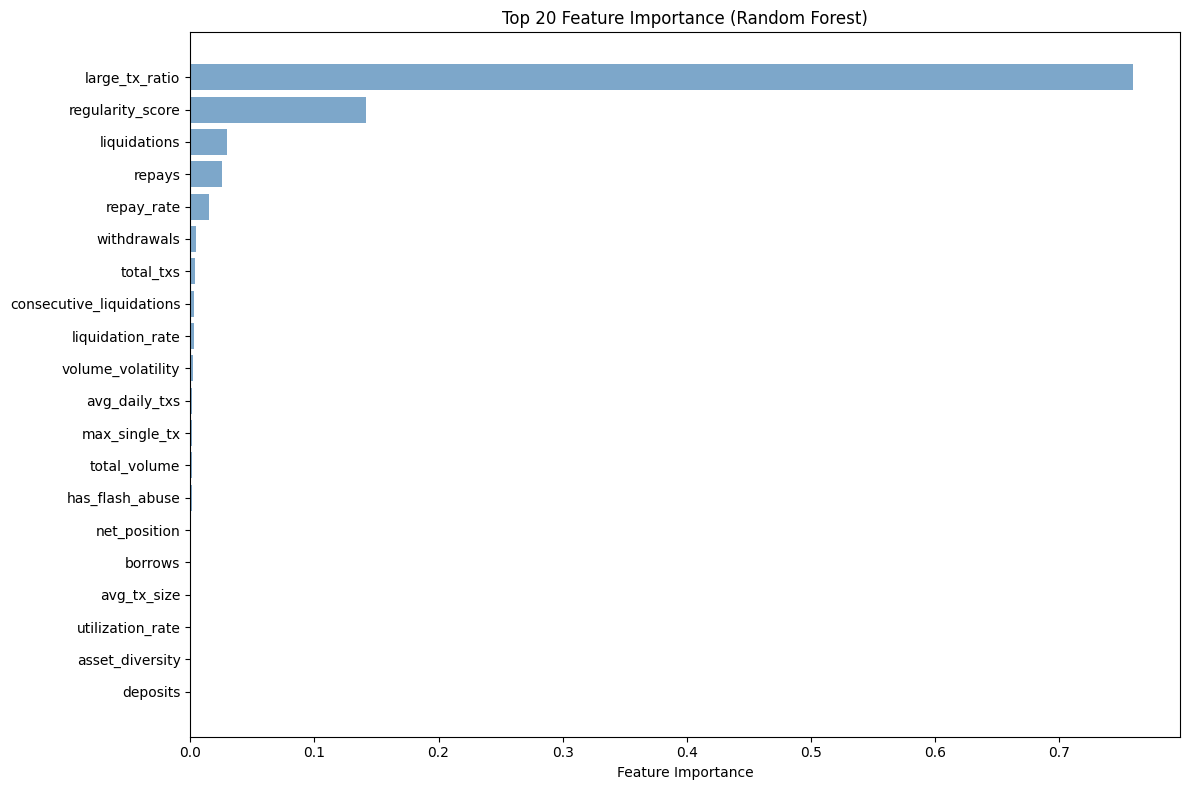


🤖 ML MODEL PERFORMANCE SUMMARY

📊 Random Forest:
   RMSE: 7.84
   R²: 0.9970
   MAE: 3.26
   CV R²: 0.9852
   ⭐ BEST MODEL

📊 Gradient Boosting:
   RMSE: 7.59
   R²: 0.9971
   MAE: 3.96
   CV R²: 0.9849

📊 Linear Regression:
   RMSE: 72.35
   R²: 0.7406
   MAE: 43.88
   CV R²: 0.7057

📊 Ridge Regression:
   RMSE: 72.36
   R²: 0.7405
   MAE: 43.89
   CV R²: 0.7060

📊 Lasso Regression:
   RMSE: 72.66
   R²: 0.7384
   MAE: 44.11
   CV R²: 0.7177

📊 SVR:
   RMSE: 122.71
   R²: 0.2537
   MAE: 66.49
   CV R²: 0.2153

💾 Saving model to defi_credit_model.pkl
✅ Model saved successfully


In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
import joblib
from typing import Dict, List, Tuple, Any

class DeFiCreditMLPredictor:
    def __init__(self):
        """Initialize the ML Credit Score Predictor"""
        # Token decimals - same as original
        self.decimals = {
            'USDC': 6, 'USDT': 6, 'DAI': 18, 'WETH': 18, 'WBTC': 8,
            'MATIC': 18, 'AAVE': 18, 'LINK': 18, 'UNI': 18
        }
        
        # Feature importance weights (for reference)
        self.feature_weights = {
            'reliability': 0.4,
            'activity': 0.3,
            'risk': 0.2,
            'engagement': 0.1
        }
        
        # Model storage
        self.models = {}
        self.scalers = {}
        self.feature_columns = []
        self.best_model_name = None
        
        # Performance metrics
        self.model_performance = {}
    
    def load_data(self, file_path: str) -> pd.DataFrame:
        """Load transaction data and do basic cleanup"""
        print(f"📊 Loading data from {file_path}")
        
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        df = pd.json_normalize(data)
        df.columns = df.columns.str.replace('actionData.', '', regex=False)
        
        # Convert timestamps and calculate USD values
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        df['usd_value'] = df.apply(self._get_usd_value, axis=1)
        
        print(f"✅ Loaded {len(df)} transactions from {df['userWallet'].nunique()} wallets")
        return df
    
    def _get_usd_value(self, row):
        """Convert raw token amounts to USD"""
        try:
            amount = float(row['amount'])
            price = float(row['assetPriceUSD'])
            symbol = row['assetSymbol']
            
            decimals = self.decimals.get(symbol, 18)
            real_amount = amount / (10 ** decimals)
            
            return real_amount * price
        except:
            return 0.0
    
    def extract_ml_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract comprehensive features for ML model"""
        print("🔍 Extracting ML features...")
        
        features_list = []
        for wallet in df['userWallet'].unique():
            wallet_data = df[df['userWallet'] == wallet].sort_values('timestamp')
            features = self._extract_wallet_features(wallet_data)
            features['wallet'] = wallet
            features_list.append(features)
        
        return pd.DataFrame(features_list)
    
    def _extract_wallet_features(self, txs: pd.DataFrame) -> Dict[str, Any]:
        """Extract comprehensive features from wallet transactions"""
        
        # Basic transaction metrics
        total_txs = len(txs)
        total_volume = txs['usd_value'].sum()
        unique_assets = txs['assetSymbol'].nunique()
        
        # Time-based features
        time_span = (txs['datetime'].max() - txs['datetime'].min()).days + 1
        avg_daily_txs = total_txs / time_span if time_span > 0 else 0
        
        # Action breakdown
        actions = txs['action'].value_counts()
        deposits = txs[txs['action'] == 'deposit']['usd_value'].sum()
        borrows = txs[txs['action'] == 'borrow']['usd_value'].sum()
        repays = txs[txs['action'] == 'repay']['usd_value'].sum()
        withdrawals = txs[txs['action'] == 'redeemunderlying']['usd_value'].sum()
        liquidations = actions.get('liquidationcall', 0)
        
        # Financial ratios
        repay_rate = (repays / borrows) if borrows > 0 else 1.0
        deposit_borrow_ratio = (deposits / borrows) if borrows > 0 else 10.0
        utilization_rate = (borrows / deposits) if deposits > 0 else 0.0
        net_position = deposits - borrows
        
        # Risk indicators
        liquidation_rate = liquidations / total_txs if total_txs > 0 else 0.0
        large_tx_ratio = len(txs[txs['usd_value'] > txs['usd_value'].quantile(0.9)]) / total_txs if total_txs > 0 else 0.0
        
        # Behavioral patterns
        is_bot = self._detect_bot_behavior(txs)
        has_flash_abuse = self._detect_flash_abuse(txs)
        regularity_score = self._calculate_regularity(txs)
        
        # Volume statistics
        avg_tx_size = total_volume / total_txs if total_txs > 0 else 0
        volume_volatility = txs['usd_value'].std() if len(txs) > 1 else 0
        max_single_tx = txs['usd_value'].max()
        
        # Asset diversity
        asset_diversity = unique_assets / max(total_txs, 1)
        top_asset_dominance = txs['assetSymbol'].value_counts().iloc[0] / total_txs if total_txs > 0 else 0
        
        # Temporal patterns
        hour_diversity = txs['datetime'].dt.hour.nunique()
        day_diversity = txs['datetime'].dt.dayofweek.nunique()
        weekend_ratio = len(txs[txs['datetime'].dt.dayofweek >= 5]) / total_txs if total_txs > 0 else 0
        
        # Advanced risk metrics
        consecutive_liquidations = self._count_consecutive_liquidations(txs)
        recovery_ability = self._calculate_recovery_ability(txs)
        
        return {
            # Basic metrics
            'total_txs': total_txs,
            'total_volume': total_volume,
            'unique_assets': unique_assets,
            'days_active': time_span,
            'avg_daily_txs': avg_daily_txs,
            
            # Financial metrics
            'deposits': deposits,
            'borrows': borrows,
            'repays': repays,
            'withdrawals': withdrawals,
            'liquidations': liquidations,
            'repay_rate': repay_rate,
            'deposit_borrow_ratio': min(deposit_borrow_ratio, 100),  # Cap extreme values
            'utilization_rate': utilization_rate,
            'net_position': net_position,
            
            # Risk metrics
            'liquidation_rate': liquidation_rate,
            'large_tx_ratio': large_tx_ratio,
            'consecutive_liquidations': consecutive_liquidations,
            'recovery_ability': recovery_ability,
            
            # Behavioral features
            'is_bot': int(is_bot),
            'has_flash_abuse': int(has_flash_abuse),
            'regularity_score': regularity_score,
            
            # Volume features
            'avg_tx_size': avg_tx_size,
            'volume_volatility': volume_volatility,
            'max_single_tx': max_single_tx,
            
            # Diversity features
            'asset_diversity': asset_diversity,
            'top_asset_dominance': top_asset_dominance,
            'hour_diversity': hour_diversity,
            'day_diversity': day_diversity,
            'weekend_ratio': weekend_ratio,
        }
    
    def _detect_bot_behavior(self, txs: pd.DataFrame) -> bool:
        """Enhanced bot detection"""
        if len(txs) < 10:
            return False
        
        # Check for repeated amounts
        amount_counts = txs['usd_value'].value_counts()
        if (amount_counts > 5).any():
            return True
        
        # Check for regular timing patterns
        time_diffs = txs['timestamp'].diff().dropna()
        if len(time_diffs) > 5:
            cv = time_diffs.std() / time_diffs.mean() if time_diffs.mean() > 0 else 0
            if cv < 0.1:  # Very regular timing
                return True
        
        # Check for identical transaction sequences
        if len(txs) >= 6:
            for i in range(len(txs) - 5):
                sequence = txs.iloc[i:i+3]['action'].tolist()
                if txs.iloc[i+3:i+6]['action'].tolist() == sequence:
                    return True
        
        return False
    
    def _detect_flash_abuse(self, txs: pd.DataFrame) -> bool:
        """Enhanced flash loan abuse detection"""
        for i in range(len(txs) - 1):
            current = txs.iloc[i]
            next_tx = txs.iloc[i + 1]
            
            # Large deposit followed by immediate withdrawal
            if (current['action'] == 'deposit' and 
                next_tx['action'] == 'redeemunderlying' and
                abs(next_tx['timestamp'] - current['timestamp']) < 300 and
                current['usd_value'] > 10000):
                return True
            
            # Borrow -> immediate repay pattern
            if (current['action'] == 'borrow' and 
                next_tx['action'] == 'repay' and
                abs(next_tx['timestamp'] - current['timestamp']) < 300 and
                current['usd_value'] > 5000):
                return True
        
        return False
    
    def _calculate_regularity(self, txs: pd.DataFrame) -> float:
        """Calculate transaction regularity score"""
        if len(txs) < 2:
            return 0.0
        
        time_diffs = txs['timestamp'].diff().dropna()
        if len(time_diffs) == 0:
            return 0.0
        
        cv = time_diffs.std() / time_diffs.mean() if time_diffs.mean() > 0 else float('inf')
        return 1.0 / (1.0 + cv)
    
    def _count_consecutive_liquidations(self, txs: pd.DataFrame) -> int:
        """Count consecutive liquidation events"""
        liquidations = txs[txs['action'] == 'liquidationcall']
        if len(liquidations) < 2:
            return 0
        
        max_consecutive = 0
        current_consecutive = 1
        
        for i in range(1, len(liquidations)):
            time_diff = liquidations.iloc[i]['timestamp'] - liquidations.iloc[i-1]['timestamp']
            if time_diff < 86400:  # Within 24 hours
                current_consecutive += 1
            else:
                max_consecutive = max(max_consecutive, current_consecutive)
                current_consecutive = 1
        
        return max(max_consecutive, current_consecutive)
    
    def _calculate_recovery_ability(self, txs: pd.DataFrame) -> float:
        """Calculate ability to recover from liquidations"""
        liquidations = txs[txs['action'] == 'liquidationcall']
        if len(liquidations) == 0:
            return 1.0
        
        recovery_scores = []
        for _, liq in liquidations.iterrows():
            # Look for deposits within 7 days after liquidation
            future_deposits = txs[
                (txs['action'] == 'deposit') &
                (txs['timestamp'] > liq['timestamp']) &
                (txs['timestamp'] <= liq['timestamp'] + 7*86400)
            ]
            
            if len(future_deposits) > 0:
                recovery_scores.append(1.0)
            else:
                recovery_scores.append(0.0)
        
        return np.mean(recovery_scores) if recovery_scores else 0.0
    
    def calculate_target_scores(self, features_df: pd.DataFrame) -> pd.DataFrame:
        """Calculate target credit scores using original algorithm"""
        print("🎯 Calculating target scores...")
        
        scores = []
        for _, wallet in features_df.iterrows():
            score = self._calculate_original_score(wallet)
            scores.append({
                'wallet': wallet['wallet'],
                'score': max(0, min(1000, score))
            })
        
        return pd.DataFrame(scores)
    
    def _calculate_original_score(self, w: pd.Series) -> float:
        """Original scoring algorithm for target values"""
        base = 500
        
        # Reliability (40% weight)
        reliability = 0
        if w['borrows'] > 0:
            reliability += min(w['repay_rate'], 1.0) * 200
        else:
            reliability += 100
        
        reliability += w['regularity_score'] * 100
        
        # Activity (30% weight)
        activity = 0
        if w['total_volume'] > 0:
            activity += min(100, np.log10(w['total_volume']) * 20)
        
        activity += min(75, w['avg_daily_txs'] * 100)
        activity += min(75, w['unique_assets'] * 15)
        
        # Risk Management (20% weight)
        risk = 200
        
        # Penalties
        if w['liquidations'] > 0:
            risk -= 200 * w['liquidations']
        if w['is_bot']:
            risk -= 100
        if w['has_flash_abuse']:
            risk -= 150
        
        # Bonuses
        if w['deposit_borrow_ratio'] > 1.5:
            risk += 50
        
        # Engagement (10% weight)
        engagement = 0
        if w['days_active'] > 30:
            engagement += min(75, w['days_active'] * 0.5)
        if w['total_txs'] > 20:
            engagement += min(75, w['total_txs'] * 2)
        
        # Weighted final score
        final_score = (
            base +
            reliability * 0.4 +
            activity * 0.3 +
            risk * 0.2 +
            engagement * 0.1
        )
        
        return final_score
    
    def prepare_ml_data(self, features_df: pd.DataFrame, target_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
        """Prepare data for ML training"""
        print("🔧 Preparing ML data...")
        
        # Merge features with targets
        ml_data = features_df.merge(target_df, on='wallet')
        
        # Define feature columns (exclude wallet and score)
        feature_columns = [col for col in ml_data.columns if col not in ['wallet', 'score']]
        self.feature_columns = feature_columns
        
        # Prepare features and target
        X = ml_data[feature_columns]
        y = ml_data['score']
        
        # Handle infinite values and NaN
        X = X.replace([np.inf, -np.inf], np.nan)
        X = X.fillna(X.median())
        
        print(f"✅ Prepared {len(X)} samples with {len(feature_columns)} features")
        return X, y
    
    def train_models(self, X: pd.DataFrame, y: pd.Series) -> Dict[str, Any]:
        """Train multiple ML models and compare performance"""
        print("🤖 Training ML models...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Initialize scalers and models
        models_to_train = {
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Lasso Regression': Lasso(alpha=1.0),
            'SVR': SVR(kernel='rbf', C=1.0)
        }
        
        results = {}
        
        for name, model in models_to_train.items():
            print(f"   Training {name}...")
            
            # Scale features for models that need it
            if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR']:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                self.scalers[name] = scaler
            else:
                X_train_scaled = X_train
                X_test_scaled = X_test
                self.scalers[name] = None
            
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
            
            # Store results
            results[name] = {
                'model': model,
                'mse': mse,
                'rmse': rmse,
                'r2': r2,
                'mae': mae,
                'cv_r2_mean': cv_scores.mean(),
                'cv_r2_std': cv_scores.std(),
                'predictions': y_pred,
                'y_test': y_test
            }
            
            self.models[name] = model
            self.model_performance[name] = {
                'rmse': rmse,
                'r2': r2,
                'mae': mae,
                'cv_r2_mean': cv_scores.mean()
            }
        
        # Find best model
        best_model = max(results.keys(), key=lambda x: results[x]['cv_r2_mean'])
        self.best_model_name = best_model
        
        print(f"✅ Best model: {best_model} (CV R² = {results[best_model]['cv_r2_mean']:.4f})")
        
        return results
    
    def optimize_best_model(self, X: pd.DataFrame, y: pd.Series) -> None:
        """Optimize hyperparameters for the best model"""
        print(f"🎛️ Optimizing {self.best_model_name}...")
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        if self.best_model_name == 'Random Forest':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            base_model = RandomForestRegressor(random_state=42)
            
        elif self.best_model_name == 'Gradient Boosting':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
            base_model = GradientBoostingRegressor(random_state=42)
            
        else:
            print(f"   No optimization implemented for {self.best_model_name}")
            return
        
        # Perform grid search
        grid_search = GridSearchCV(
            base_model, param_grid, cv=5, scoring='r2', n_jobs=-1
        )
        
        # Scale data if needed
        if self.scalers[self.best_model_name] is not None:
            X_train_scaled = self.scalers[self.best_model_name].fit_transform(X_train)
        else:
            X_train_scaled = X_train
        
        grid_search.fit(X_train_scaled, y_train)
        
        # Update best model
        self.models[self.best_model_name] = grid_search.best_estimator_
        
        print(f"✅ Best parameters: {grid_search.best_params_}")
        print(f"✅ Best CV score: {grid_search.best_score_:.4f}")
    
    def analyze_feature_importance(self) -> pd.DataFrame:
        """Analyze feature importance for tree-based models"""
        print("📊 Analyzing feature importance...")
        
        if self.best_model_name not in ['Random Forest', 'Gradient Boosting']:
            print(f"   Feature importance not available for {self.best_model_name}")
            return pd.DataFrame()
        
        model = self.models[self.best_model_name]
        
        # Get feature importance
        importance = model.feature_importances_
        
        # Create DataFrame
        feature_importance = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return feature_importance
    
    def create_model_comparison_plots(self, results: Dict[str, Any]) -> None:
        """Create visualization comparing model performance"""
        print("📈 Creating model comparison plots...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('ML Model Performance Comparison', fontsize=16, fontweight='bold')
        
        # Model performance metrics
        models = list(results.keys())
        r2_scores = [results[model]['r2'] for model in models]
        rmse_scores = [results[model]['rmse'] for model in models]
        cv_scores = [results[model]['cv_r2_mean'] for model in models]
        
        # R² comparison
        axes[0, 0].bar(models, r2_scores, color='skyblue', alpha=0.7)
        axes[0, 0].set_title('R² Score (Test Set)')
        axes[0, 0].set_ylabel('R² Score')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # RMSE comparison
        axes[0, 1].bar(models, rmse_scores, color='lightcoral', alpha=0.7)
        axes[0, 1].set_title('RMSE (Test Set)')
        axes[0, 1].set_ylabel('RMSE')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Cross-validation scores
        axes[1, 0].bar(models, cv_scores, color='lightgreen', alpha=0.7)
        axes[1, 0].set_title('Cross-Validation R² Score')
        axes[1, 0].set_ylabel('CV R² Score')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Prediction vs Actual for best model
        best_result = results[self.best_model_name]
        axes[1, 1].scatter(best_result['y_test'], best_result['predictions'], alpha=0.6)
        axes[1, 1].plot([0, 1000], [0, 1000], 'r--', lw=2)
        axes[1, 1].set_xlabel('Actual Score')
        axes[1, 1].set_ylabel('Predicted Score')
        axes[1, 1].set_title(f'Predictions vs Actual ({self.best_model_name})')
        
        plt.tight_layout()
        plt.savefig('ml_model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_feature_importance_plot(self, feature_importance: pd.DataFrame) -> None:
        """Create feature importance visualization"""
        if feature_importance.empty:
            return
        
        print("📊 Creating feature importance plot...")
        
        plt.figure(figsize=(12, 8))
        
        # Plot top 20 features
        top_features = feature_importance.head(20)
        
        plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 20 Feature Importance ({self.best_model_name})')
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def predict_scores(self, new_features: pd.DataFrame) -> pd.DataFrame:
        """Predict credit scores for new data"""
        print("🔮 Predicting credit scores...")
        
        if self.best_model_name is None:
            raise ValueError("No trained model available. Train models first.")
        
        # Prepare features
        X_new = new_features[self.feature_columns]
        X_new = X_new.replace([np.inf, -np.inf], np.nan)
        X_new = X_new.fillna(X_new.median())
        
        # Scale if needed
        if self.scalers[self.best_model_name] is not None:
            X_new_scaled = self.scalers[self.best_model_name].transform(X_new)
        else:
            X_new_scaled = X_new
        
        # Make predictions
        predictions = self.models[self.best_model_name].predict(X_new_scaled)
        
        # Create results DataFrame
        results = pd.DataFrame({
            'wallet': new_features['wallet'],
            'predicted_score': np.clip(predictions, 0, 1000)
        })
        
        return results.sort_values('predicted_score', ascending=False)
    
    def save_model(self, filepath: str) -> None:
        """Save trained model and scalers"""
        print(f"💾 Saving model to {filepath}")
        
        model_data = {
            'best_model': self.models[self.best_model_name],
            'best_model_name': self.best_model_name,
            'scaler': self.scalers[self.best_model_name],
            'feature_columns': self.feature_columns,
            'model_performance': self.model_performance
        }
        
        joblib.dump(model_data, filepath)
        print("✅ Model saved successfully")
    
    def load_model(self, filepath: str) -> None:
        """Load trained model and scalers"""
        print(f"📂 Loading model from {filepath}")
        
        model_data = joblib.load(filepath)
        
        self.models[model_data['best_model_name']] = model_data['best_model']
        self.best_model_name = model_data['best_model_name']
        self.scalers[model_data['best_model_name']] = model_data['scaler']
        self.feature_columns = model_data['feature_columns']
        self.model_performance = model_data['model_performance']
        
        print("✅ Model loaded successfully")
    
    def print_model_summary(self) -> None:
        """Print summary of model performance"""
        print("\n" + "="*50)
        print("🤖 ML MODEL PERFORMANCE SUMMARY")
        print("="*50)
        
        for model_name, performance in self.model_performance.items():
            print(f"\n📊 {model_name}:")
            print(f"   RMSE: {performance['rmse']:.2f}")
            print(f"   R²: {performance['r2']:.4f}")
            print(f"   MAE: {performance['mae']:.2f}")
            print(f"   CV R²: {performance['cv_r2_mean']:.4f}")
            
            if model_name == self.best_model_name:
                print("   ⭐ BEST MODEL")
        
        print("\n" + "="*50)

# Example usage
def main():
    # Initialize predictor
    predictor = DeFiCreditMLPredictor()
    
    # Load and process data
    df = predictor.load_data("transactions.json")
    features_df = predictor.extract_ml_features(df)
    target_df = predictor.calculate_target_scores(features_df)
    
    # Prepare ML data
    X, y = predictor.prepare_ml_data(features_df, target_df)
    
    # Train models
    results = predictor.train_models(X, y)
    
    # Optimize best model
    predictor.optimize_best_model(X, y)
    
    # Analyze feature importance
    feature_importance = predictor.analyze_feature_importance()
    
    # Create visualizations
    predictor.create_model_comparison_plots(results)
    predictor.create_feature_importance_plot(feature_importance)
    
    # Print summary
    predictor.print_model_summary()
    
    # Save model
    predictor.save_model("defi_credit_model.pkl")
    
    # Example prediction on new data
    # new_predictions = predictor.predict_scores(features_df.head(10))
    # print("\n🔮 Sample Predictions:")
    # print(new_predictions)
    
    return predictor, features_df, target_df

if __name__ == "__main__":
    predictor, features, targets = main()

📊 Loading data from transactions.json
✅ Loaded 100000 transactions from 3497 wallets
🔍 Analyzing wallet behavior...
🎯 Calculating credit scores...

🏆 DEFI CREDIT SCORING RESULTS
📊 Total Wallets: 3497
📈 Average Score: 700.9
📉 Median Score: 649.0
🎯 Score Range: 0 - 1000

📋 Score Distribution:
   🌟 Excellent (800-1000): 550 wallets
   ✅ Good (600-799): 2744 wallets
   ⚖️  Fair (400-599): 197 wallets
   ⚠️  Poor (200-399): 3 wallets
   🚨 Very Poor (0-199): 3 wallets

🥇 Top 5 Wallets:
   1. 0x04c252241472f... → 1000
   2. 0x02e75b9654e0d... → 1000
   3. 0x039c732095611... → 1000
   4. 0x0149e057c5cf8... → 1000
   5. 0x014b0094e8c92... → 1000

🚨 Bottom 5 Wallets:
   3493. 0x0256b3d533b38... → 318
   3494. 0x02eb2ee0867dc... → 236
   3495. 0x04288d0b8bc62... → 161
   3496. 0x04426a58fdd02... → 0
   3497. 0x02a16f8df2b11... → 0


🏆 DEFI CREDIT SCORING RESULTS
📊 Total Wallets: 3497
📈 Average Score: 700.9
📉 Median Score: 649.0
🎯 Score Range: 0 - 1000

📋 Score Distribution:
   🌟 Excellent (800-10

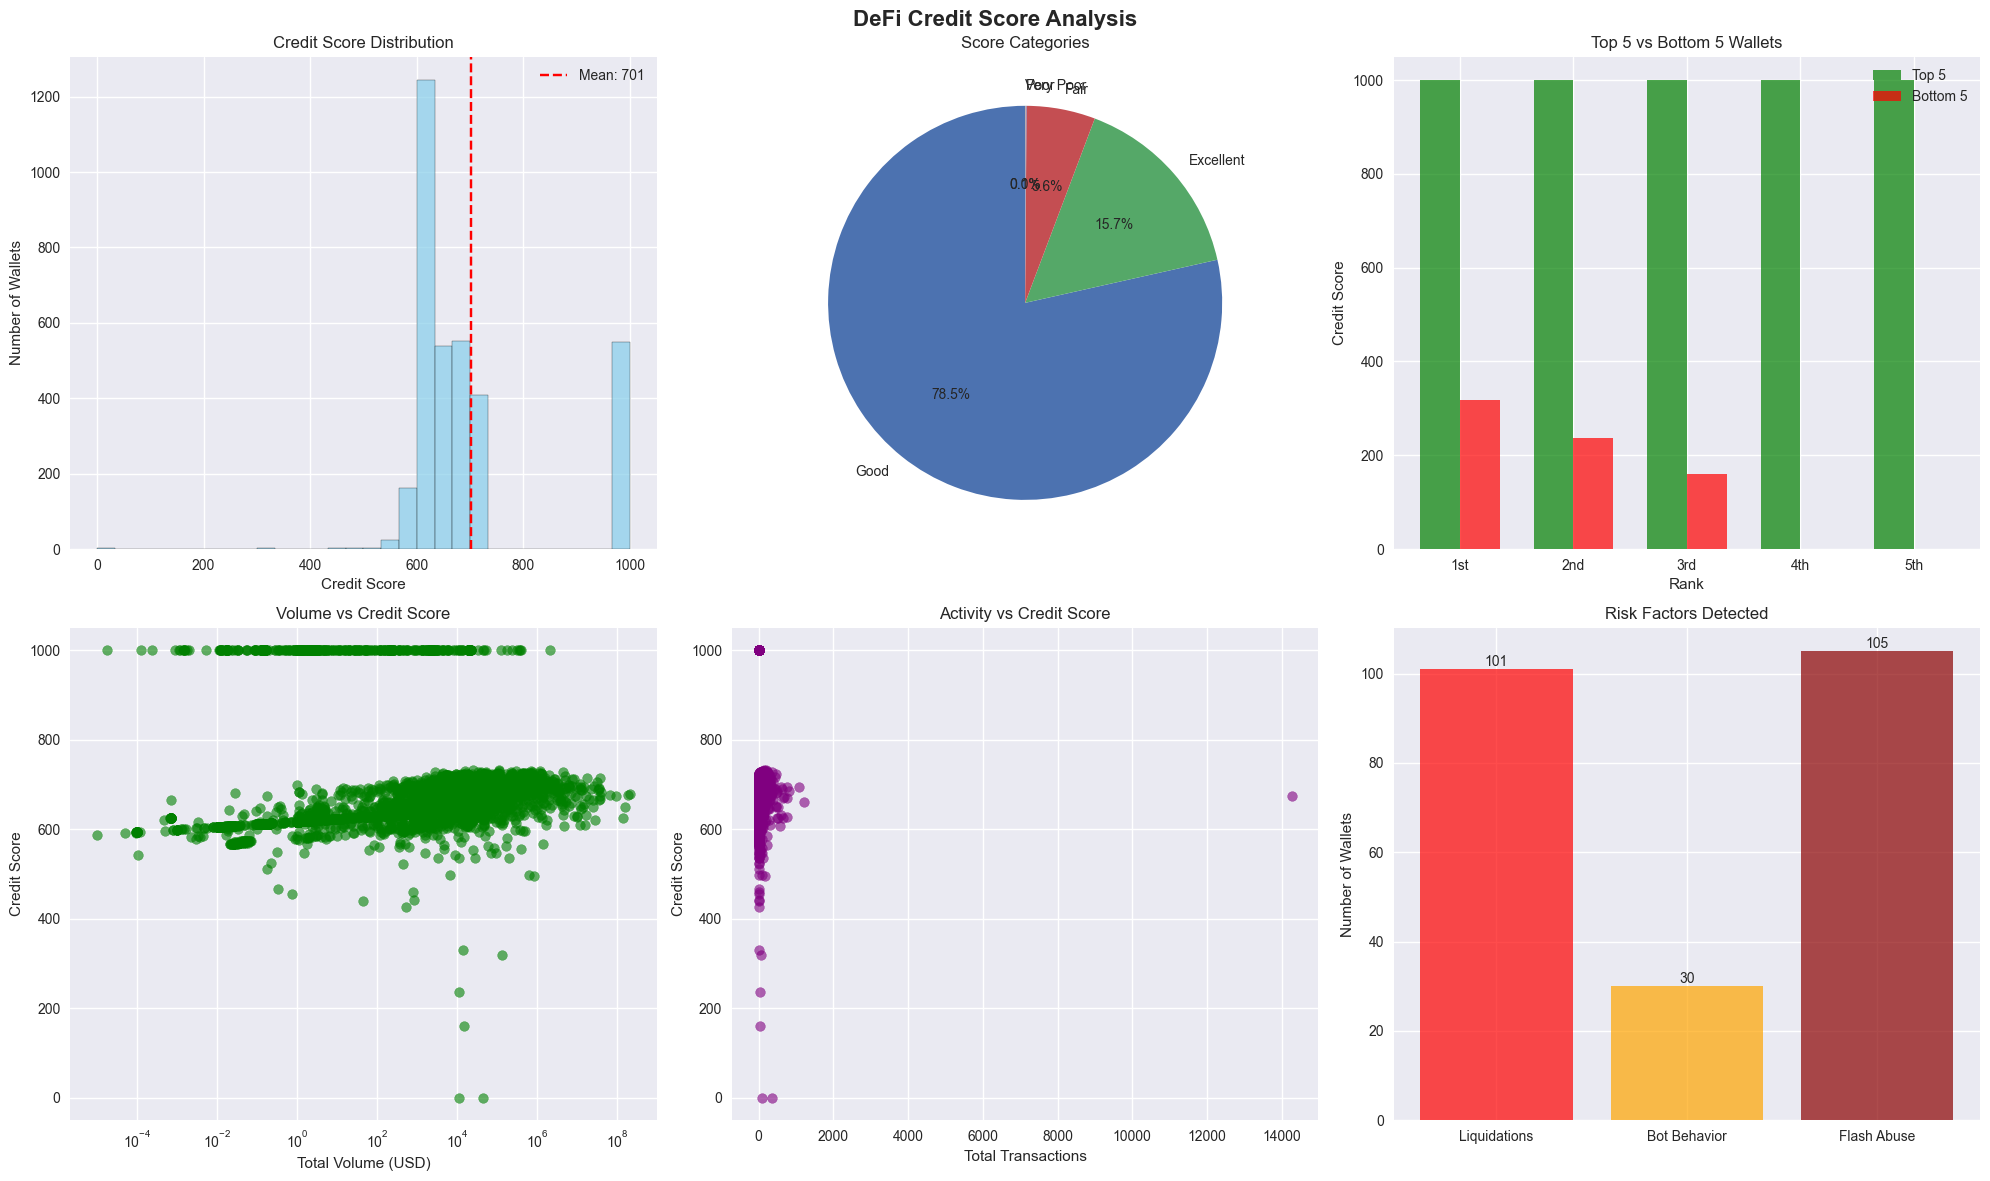

🏆 Creating top/bottom performers analysis...


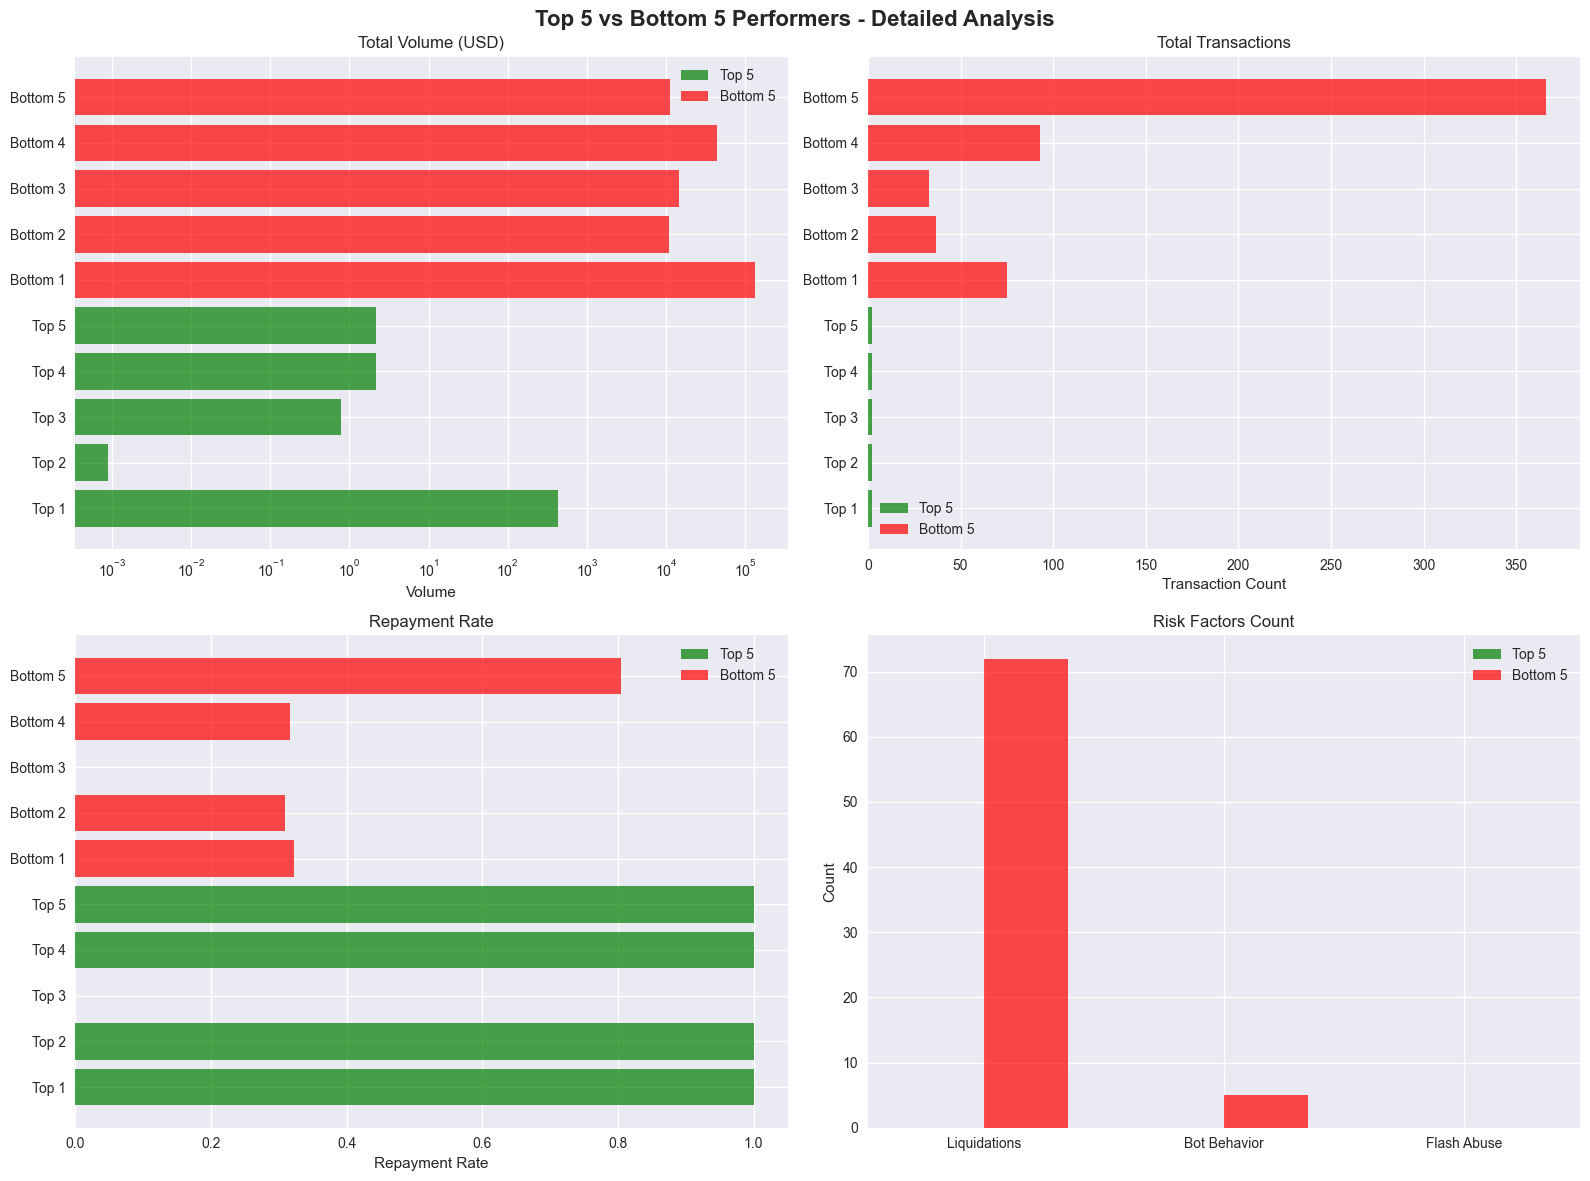


💾 Results saved to:
   📊 wallet_scores.csv - Basic scores
   📈 detailed_wallet_analysis.csv - Full analysis
   📸 credit_score_analysis.png - Main charts
   📸 top_bottom_analysis.png - Top/Bottom comparison


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class CreditScorer:
    def __init__(self):
        # Token decimals - yeah, crypto is weird like this
        self.decimals = {
            'USDC': 6, 'USDT': 6, 'DAI': 18, 'WETH': 18, 'WBTC': 8,
            'MATIC': 18, 'AAVE': 18, 'LINK': 18, 'UNI': 18
        }
        
        # What matters most for credit scoring
        self.weights = {
            'reliability': 0.4,    # Do they pay back loans?
            'activity': 0.3,       # How active are they?
            'risk': 0.2,          # Do they avoid liquidations?
            'engagement': 0.1      # Long-term user?
        }
        
        # Red flags that hurt your score
        self.penalties = {
            'liquidation': 200,    # Got liquidated? Big penalty
            'bot_pattern': 100,    # Acting like a bot? Not good
            'flash_abuse': 150,    # Exploiting flash loans? Nope
            'erratic': 50         # Weird patterns? Suspicious
        }
    
    def load_data(self, file_path):
        """Load transaction data and do basic cleanup"""
        print(f"📊 Loading data from {file_path}")
        
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        df = pd.json_normalize(data)
        
        # Clean up column names - remove the annoying 'actionData.' prefix
        df.columns = df.columns.str.replace('actionData.', '', regex=False)
        
        # Convert timestamps and calculate USD values
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        df['usd_value'] = df.apply(self._get_usd_value, axis=1)
        
        print(f"✅ Loaded {len(df)} transactions from {df['userWallet'].nunique()} wallets")
        return df
    
    def _get_usd_value(self, row):
        """Convert raw token amounts to USD"""
        try:
            amount = float(row['amount'])
            price = float(row['assetPriceUSD'])
            symbol = row['assetSymbol']
            
            # Handle different token decimals
            decimals = self.decimals.get(symbol, 18)
            real_amount = amount / (10 ** decimals)
            
            return real_amount * price
        except:
            return 0.0
    
    def analyze_wallets(self, df):
        """Extract features for each wallet"""
        print("🔍 Analyzing wallet behavior...")
        
        results = []
        for wallet in df['userWallet'].unique():
            wallet_data = df[df['userWallet'] == wallet].sort_values('timestamp')
            features = self._extract_features(wallet_data)
            features['wallet'] = wallet
            results.append(features)
        
        return pd.DataFrame(results)
    
    def _extract_features(self, txs):
        """Extract behavioral features from wallet transactions"""
        # Basic stats
        total_txs = len(txs)
        total_volume = txs['usd_value'].sum()
        unique_assets = txs['assetSymbol'].nunique()
        
        # Time analysis
        time_span = (txs['datetime'].max() - txs['datetime'].min()).days + 1
        
        # Action breakdown
        actions = txs['action'].value_counts()
        deposits = txs[txs['action'] == 'deposit']['usd_value'].sum()
        borrows = txs[txs['action'] == 'borrow']['usd_value'].sum()
        repays = txs[txs['action'] == 'repay']['usd_value'].sum()
        liquidations = actions.get('liquidationcall', 0)
        
        # Calculate key metrics
        repay_rate = (repays / borrows) if borrows > 0 else 1.0
        deposit_borrow_ratio = (deposits / borrows) if borrows > 0 else float('inf')
        
        # Pattern detection
        is_bot = self._looks_like_bot(txs)
        has_flash_abuse = self._detect_flash_abuse(txs)
        regularity = self._calculate_regularity(txs)
        
        return {
            'total_txs': total_txs,
            'volume': total_volume,
            'assets': unique_assets,
            'days_active': time_span,
            'deposits': deposits,
            'borrows': borrows,
            'repays': repays,
            'liquidations': liquidations,
            'repay_rate': repay_rate,
            'deposit_ratio': deposit_borrow_ratio,
            'is_bot': is_bot,
            'flash_abuse': has_flash_abuse,
            'regularity': regularity,
            'avg_tx_size': total_volume / total_txs if total_txs > 0 else 0
        }
    
    def _looks_like_bot(self, txs):
        """Check if transactions look automated"""
        if len(txs) < 10:
            return False
        
        # Same amounts repeated too often?
        amount_counts = txs['usd_value'].value_counts()
        if (amount_counts > 5).any():
            return True
        
        # Too regular timing?
        time_diffs = txs['timestamp'].diff().dropna()
        if len(time_diffs) > 5 and time_diffs.var() < 3600:
            return True
        
        return False
    
    def _detect_flash_abuse(self, txs):
        """Look for flash loan abuse patterns"""
        for i in range(len(txs) - 1):
            current = txs.iloc[i]
            next_tx = txs.iloc[i + 1]
            
            # Large deposit followed by immediate withdrawal?
            if (current['action'] == 'deposit' and 
                next_tx['action'] == 'redeemunderlying' and
                abs(next_tx['timestamp'] - current['timestamp']) < 300 and
                current['usd_value'] > 10000):
                return True
        return False
    
    def _calculate_regularity(self, txs):
        """How regular are the transactions? (0-1 scale)"""
        if len(txs) < 2:
            return 0.0
        
        time_diffs = txs['timestamp'].diff().dropna()
        if len(time_diffs) == 0:
            return 0.0
        
        cv = time_diffs.std() / time_diffs.mean() if time_diffs.mean() > 0 else float('inf')
        return 1.0 / (1.0 + cv)
    
    def calculate_scores(self, features_df):
        """Calculate credit scores (0-1000)"""
        print("🎯 Calculating credit scores...")
        
        scores = []
        for _, wallet in features_df.iterrows():
            score = self._score_wallet(wallet)
            scores.append({
                'wallet': wallet['wallet'],
                'score': max(0, min(1000, score))
            })
        
        return pd.DataFrame(scores).sort_values('score', ascending=False)
    
    def _score_wallet(self, w):
        """Score individual wallet"""
        base = 500  # Everyone starts neutral
        
        # Reliability (40% weight)
        reliability = 0
        if w['borrows'] > 0:
            reliability += min(w['repay_rate'], 1.0) * 200  # Repayment history
        else:
            reliability += 100  # No borrowing is safe
        
        reliability += w['regularity'] * 100  # Consistent behavior
        
        # Activity (30% weight)  
        activity = 0
        if w['volume'] > 0:
            activity += min(100, np.log10(w['volume']) * 20)  # Volume score
        
        activity += min(75, w['total_txs'] / w['days_active'] * 100)  # Frequency
        activity += min(75, w['assets'] * 15)  # Diversification
        
        # Risk Management (20% weight)
        risk = 200  # Start with good risk score
        
        # Apply penalties
        if w['liquidations'] > 0:
            risk -= self.penalties['liquidation'] * w['liquidations']
        if w['is_bot']:
            risk -= self.penalties['bot_pattern']
        if w['flash_abuse']:
            risk -= self.penalties['flash_abuse']
        
        # Bonus for good collateral ratio
        if w['deposit_ratio'] > 1.5:
            risk += 50
        
        # Engagement (10% weight)
        engagement = 0
        if w['days_active'] > 30:
            engagement += min(75, w['days_active'] * 0.5)
        if w['total_txs'] > 20:
            engagement += min(75, w['total_txs'] * 2)
        
        # Weighted final score
        final_score = (
            base +
            reliability * self.weights['reliability'] +
            activity * self.weights['activity'] +
            risk * self.weights['risk'] +
            engagement * self.weights['engagement']
        )
        
        return final_score
    
    def create_visualizations(self, scores_df, features_df):
        """Create some nice charts"""
        print("📈 Creating visualizations...")
        
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('DeFi Credit Score Analysis', fontsize=16, fontweight='bold')
        
        # Score distribution
        axes[0, 0].hist(scores_df['score'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Credit Score Distribution')
        axes[0, 0].set_xlabel('Credit Score')
        axes[0, 0].set_ylabel('Number of Wallets')
        axes[0, 0].axvline(scores_df['score'].mean(), color='red', linestyle='--', 
                          label=f'Mean: {scores_df["score"].mean():.0f}')
        axes[0, 0].legend()
        
        # Score categories
        score_categories = pd.cut(scores_df['score'], 
                                bins=[0, 200, 400, 600, 800, 1000],
                                labels=['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent'])
        category_counts = score_categories.value_counts()
        
        axes[0, 1].pie(category_counts.values, labels=category_counts.index, 
                      autopct='%1.1f%%', startangle=90)
        axes[0, 1].set_title('Score Categories')
        
        # Top 5 vs Bottom 5 comparison
        top_5 = scores_df.head(5)
        bottom_5 = scores_df.tail(5)
        
        x_pos = np.arange(5)
        width = 0.35
        
        axes[0, 2].bar(x_pos - width/2, top_5['score'], width, label='Top 5', color='green', alpha=0.7)
        axes[0, 2].bar(x_pos + width/2, bottom_5['score'], width, label='Bottom 5', color='red', alpha=0.7)
        axes[0, 2].set_title('Top 5 vs Bottom 5 Wallets')
        axes[0, 2].set_ylabel('Credit Score')
        axes[0, 2].set_xlabel('Rank')
        axes[0, 2].legend()
        axes[0, 2].set_xticks(x_pos)
        axes[0, 2].set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'])
        
        # Volume vs Score
        merged = scores_df.merge(features_df[['wallet', 'volume']], on='wallet')
        scatter = axes[1, 0].scatter(merged['volume'], merged['score'], alpha=0.6, color='green')
        axes[1, 0].set_xlabel('Total Volume (USD)')
        axes[1, 0].set_ylabel('Credit Score')
        axes[1, 0].set_title('Volume vs Credit Score')
        axes[1, 0].set_xscale('log')
        
        # Transaction count vs Score
        merged = scores_df.merge(features_df[['wallet', 'total_txs']], on='wallet')
        axes[1, 1].scatter(merged['total_txs'], merged['score'], alpha=0.6, color='purple')
        axes[1, 1].set_xlabel('Total Transactions')
        axes[1, 1].set_ylabel('Credit Score')
        axes[1, 1].set_title('Activity vs Credit Score')
        
        # Risk analysis chart
        risk_data = features_df[['liquidations', 'is_bot', 'flash_abuse']].copy()
        risk_data['liquidations'] = risk_data['liquidations'] > 0
        
        risk_summary = pd.DataFrame({
            'Risk Factor': ['Liquidations', 'Bot Behavior', 'Flash Abuse'],
            'Count': [
                risk_data['liquidations'].sum(),
                risk_data['is_bot'].sum(),
                risk_data['flash_abuse'].sum()
            ]
        })
        
        bars = axes[1, 2].bar(risk_summary['Risk Factor'], risk_summary['Count'], 
                     color=['red', 'orange', 'darkred'], alpha=0.7)
        axes[1, 2].set_title('Risk Factors Detected')
        axes[1, 2].set_ylabel('Number of Wallets')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('credit_score_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create detailed top/bottom performers chart
        self._create_top_bottom_chart(scores_df, features_df)
    
    def _create_top_bottom_chart(self, scores_df, features_df):
        """Create detailed analysis of top and bottom performers"""
        print("🏆 Creating top/bottom performers analysis...")
        
        # Merge scores with features for detailed analysis
        detailed_df = scores_df.merge(features_df, on='wallet')
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Top 5 vs Bottom 5 Performers - Detailed Analysis', fontsize=16, fontweight='bold')
        
        top_5 = detailed_df.head(5)
        bottom_5 = detailed_df.tail(5)
        
        # Volume comparison
        axes[0, 0].barh(range(5), top_5['volume'], color='green', alpha=0.7, label='Top 5')
        axes[0, 0].barh(range(5, 10), bottom_5['volume'], color='red', alpha=0.7, label='Bottom 5')
        axes[0, 0].set_title('Total Volume (USD)')
        axes[0, 0].set_xlabel('Volume')
        axes[0, 0].set_xscale('log')
        axes[0, 0].set_yticks(range(10))
        axes[0, 0].set_yticklabels([f'Top {i+1}' for i in range(5)] + [f'Bottom {i+1}' for i in range(5)])
        axes[0, 0].legend()
        
        # Transaction count comparison
        axes[0, 1].barh(range(5), top_5['total_txs'], color='green', alpha=0.7, label='Top 5')
        axes[0, 1].barh(range(5, 10), bottom_5['total_txs'], color='red', alpha=0.7, label='Bottom 5')
        axes[0, 1].set_title('Total Transactions')
        axes[0, 1].set_xlabel('Transaction Count')
        axes[0, 1].set_yticks(range(10))
        axes[0, 1].set_yticklabels([f'Top {i+1}' for i in range(5)] + [f'Bottom {i+1}' for i in range(5)])
        axes[0, 1].legend()
        
        # Repayment rate comparison
        axes[1, 0].barh(range(5), top_5['repay_rate'], color='green', alpha=0.7, label='Top 5')
        axes[1, 0].barh(range(5, 10), bottom_5['repay_rate'], color='red', alpha=0.7, label='Bottom 5')
        axes[1, 0].set_title('Repayment Rate')
        axes[1, 0].set_xlabel('Repayment Rate')
        axes[1, 0].set_yticks(range(10))
        axes[1, 0].set_yticklabels([f'Top {i+1}' for i in range(5)] + [f'Bottom {i+1}' for i in range(5)])
        axes[1, 0].legend()
        
        # Risk factors comparison
        top_risks = [top_5['liquidations'].sum(), top_5['is_bot'].sum(), top_5['flash_abuse'].sum()]
        bottom_risks = [bottom_5['liquidations'].sum(), bottom_5['is_bot'].sum(), bottom_5['flash_abuse'].sum()]
        
        x = np.arange(3)
        width = 0.35
        
        axes[1, 1].bar(x - width/2, top_risks, width, label='Top 5', color='green', alpha=0.7)
        axes[1, 1].bar(x + width/2, bottom_risks, width, label='Bottom 5', color='red', alpha=0.7)
        axes[1, 1].set_title('Risk Factors Count')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(['Liquidations', 'Bot Behavior', 'Flash Abuse'])
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.savefig('top_bottom_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def print_detailed_performers(self, scores_df, features_df):
        """Print detailed analysis of top and bottom performers"""
        detailed_df = scores_df.merge(features_df, on='wallet')
        
        print("\n" + "🏆" * 25)
        print("TOP 5 PERFORMERS - HALL OF FAME")
        print("🏆" * 25)
        
        for i, (_, wallet) in enumerate(detailed_df.head(5).iterrows()):
            print(f"\n🥇 #{i+1} - {wallet['wallet'][:15]}...")
            print(f"   Score: {wallet['score']:.0f}/1000")
            print(f"   Volume: ${wallet['volume']:,.2f}")
            print(f"   Transactions: {wallet['total_txs']}")
            print(f"   Repayment Rate: {wallet['repay_rate']:.1%}")
            print(f"   Assets Used: {wallet['assets']}")
            print(f"   Days Active: {wallet['days_active']}")
            
            # Risk indicators
            risks = []
            if wallet['liquidations'] > 0:
                risks.append(f"⚠️ {wallet['liquidations']} liquidations")
            if wallet['is_bot']:
                risks.append("🤖 Bot-like behavior")
            if wallet['flash_abuse']:
                risks.append("⚡ Flash loan abuse")
            
            if risks:
                print(f"   Risk Flags: {', '.join(risks)}")
            else:
                print("   Risk Flags: ✅ None (Clean record)")
        
        print("\n" + "🚨" * 25)
        print("BOTTOM 5 PERFORMERS - HALL OF SHAME")
        print("🚨" * 25)
        
        for i, (_, wallet) in enumerate(detailed_df.tail(5).iterrows()):
            print(f"\n🚨 #{len(detailed_df) - 4 + i} - {wallet['wallet'][:15]}...")
            print(f"   Score: {wallet['score']:.0f}/1000")
            print(f"   Volume: ${wallet['volume']:,.2f}")
            print(f"   Transactions: {wallet['total_txs']}")
            print(f"   Repayment Rate: {wallet['repay_rate']:.1%}")
            print(f"   Assets Used: {wallet['assets']}")
            print(f"   Days Active: {wallet['days_active']}")
            
            # Risk indicators
            risks = []
            if wallet['liquidations'] > 0:
                risks.append(f"⚠️ {wallet['liquidations']} liquidations")
            if wallet['is_bot']:
                risks.append("🤖 Bot-like behavior")
            if wallet['flash_abuse']:
                risks.append("⚡ Flash loan abuse")
            
            if risks:
                print(f"   Risk Flags: {', '.join(risks)}")
            else:
                print("   Risk Flags: ✅ None")
            
            # Analysis of why they scored low
            issues = []
            if wallet['repay_rate'] < 0.8:
                issues.append("Poor repayment history")
            if wallet['total_txs'] < 5:
                issues.append("Very low activity")
            if wallet['liquidations'] > 0:
                issues.append("Liquidation events")
            if wallet['volume'] < 100:
                issues.append("Minimal volume")
            
            if issues:
                print(f"   Issues: {', '.join(issues)}")
        
        print("\n" + "=" * 50)
    
    def print_summary(self, scores_df):
        """Print a nice summary"""
        print("\n" + "="*50)
        print("🏆 DEFI CREDIT SCORING RESULTS")
        print("="*50)
        print(f"📊 Total Wallets: {len(scores_df)}")
        print(f"📈 Average Score: {scores_df['score'].mean():.1f}")
        print(f"📉 Median Score: {scores_df['score'].median():.1f}")
        print(f"🎯 Score Range: {scores_df['score'].min():.0f} - {scores_df['score'].max():.0f}")
        
        # Score distribution
        excellent = len(scores_df[scores_df['score'] >= 800])
        good = len(scores_df[(scores_df['score'] >= 600) & (scores_df['score'] < 800)])
        fair = len(scores_df[(scores_df['score'] >= 400) & (scores_df['score'] < 600)])
        poor = len(scores_df[(scores_df['score'] >= 200) & (scores_df['score'] < 400)])
        very_poor = len(scores_df[scores_df['score'] < 200])
        
        print(f"\n📋 Score Distribution:")
        print(f"   🌟 Excellent (800-1000): {excellent} wallets")
        print(f"   ✅ Good (600-799): {good} wallets")
        print(f"   ⚖️  Fair (400-599): {fair} wallets")
        print(f"   ⚠️  Poor (200-399): {poor} wallets")
        print(f"   🚨 Very Poor (0-199): {very_poor} wallets")
        
        print(f"\n🥇 Top 5 Wallets:")
        for i, (_, row) in enumerate(scores_df.head(5).iterrows()):
            print(f"   {i+1}. {row['wallet'][:15]}... → {row['score']:.0f}")
        
        print(f"\n🚨 Bottom 5 Wallets:")
        for i, (_, row) in enumerate(scores_df.tail(5).iterrows()):
            print(f"   {len(scores_df) - 4 + i}. {row['wallet'][:15]}... → {row['score']:.0f}")
        
        print("\n" + "="*50)
        """Print a nice summary"""
        print("\n" + "="*50)
        print("🏆 DEFI CREDIT SCORING RESULTS")
        print("="*50)
        print(f"📊 Total Wallets: {len(scores_df)}")
        print(f"📈 Average Score: {scores_df['score'].mean():.1f}")
        print(f"📉 Median Score: {scores_df['score'].median():.1f}")
        print(f"🎯 Score Range: {scores_df['score'].min():.0f} - {scores_df['score'].max():.0f}")
        
        # Score distribution
        excellent = len(scores_df[scores_df['score'] >= 800])
        good = len(scores_df[(scores_df['score'] >= 600) & (scores_df['score'] < 800)])
        fair = len(scores_df[(scores_df['score'] >= 400) & (scores_df['score'] < 600)])
        poor = len(scores_df[(scores_df['score'] >= 200) & (scores_df['score'] < 400)])
        very_poor = len(scores_df[scores_df['score'] < 200])
        
        print(f"\n📋 Score Distribution:")
        print(f"   🌟 Excellent (800-1000): {excellent} wallets")
        print(f"   ✅ Good (600-799): {good} wallets")
        print(f"   ⚖️  Fair (400-599): {fair} wallets")
        print(f"   ⚠️  Poor (200-399): {poor} wallets")
        print(f"   🚨 Very Poor (0-199): {very_poor} wallets")
        
        print(f"\n🥇 Top 5 Wallets:")
        for i, (_, row) in enumerate(scores_df.head(5).iterrows()):
            print(f"   {i+1}. {row['wallet'][:10]}... → {row['score']:.0f}")
        
        print("\n" + "="*50)

# Main execution
def main():
    scorer = CreditScorer()
    
    # Load and process data
    df = scorer.load_data("transactions.json")
    features_df = scorer.analyze_wallets(df)
    scores_df = scorer.calculate_scores(features_df)
    
    # Show results
    scorer.print_summary(scores_df)
    scorer.print_detailed_performers(scores_df, features_df)
    scorer.create_visualizations(scores_df, features_df)
    
    # Save results
    scores_df.to_csv("wallet_scores.csv", index=False)
    
    # Save detailed analysis
    detailed_df = scores_df.merge(features_df, on='wallet')
    detailed_df.to_csv("detailed_wallet_analysis.csv", index=False)
    
    print(f"\n💾 Results saved to:")
    print(f"   📊 wallet_scores.csv - Basic scores")
    print(f"   📈 detailed_wallet_analysis.csv - Full analysis")
    print(f"   📸 credit_score_analysis.png - Main charts")
    print(f"   📸 top_bottom_analysis.png - Top/Bottom comparison")
    
    return scores_df, features_df

if __name__ == "__main__":
    scores, features = main()